# Insights from AirBnB data from Rio de Janeiro

### Parts

| Section | Part                                 |  
| :-      |:-                                    |          
| 1       | [Exploratory data analysis](#eda)                 | 
| 2       | [Preprocessing](#pp) |      
| 3       | [Modeling](#modeling)     | 
| 4       | [Challenges and future work](#challenges)                     | 
| 5       | [Acknowledgments](#ack)      |  

### Questions

This notebook aims to answer the questions below:
1. A good tip for writing listing titles
2. Which is the best period to rent an AirBnb in rio?
3. Which features are most  important to listing prices?



### Importing necessary libs

In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import holidays
from wordcloud import WordCloud

In [11]:
listings_df = pd.read_csv('data/listings.csv')
listings_summary_df = pd.read_csv('data/listings_summary.csv')
calendar_df = pd.read_csv('data/calendar.csv')

- Listings.csv contains the full airbnb dataset of the city of Rio de Janeiro, Brazil.
- Listings_summary.csv is a resumed and cleaned version of this same dataset.
- Calendar.csv contains the price of each listing during the period of one year.

<a id="eda"/>

### Exploratory data analysis

In [12]:
listings_df.head()

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,17878,https://www.airbnb.com/rooms/17878,20210222161029,2021-02-23,"Very Nice 2Br in Copacabana w. balcony, fast WiFi",Discounts for long term stays. <br />- Large b...,This is the one of the bests spots in Rio. Bec...,https://a0.muscache.com/pictures/65320518/3069...,68997,https://www.airbnb.com/users/show/68997,...,10.0,10.0,9.0,NaN,t,1,1,0,0,2.01
1,24480,https://www.airbnb.com/rooms/24480,20210222161029,2021-02-23,Nice and cozy near Ipanema Beach,My studio is located in the best of Ipanema. ...,"The beach, the lagoon, Ipanema is a great loca...",https://a0.muscache.com/pictures/11955612/b28e...,99249,https://www.airbnb.com/users/show/99249,...,10.0,10.0,9.0,NaN,f,1,1,0,0,0.67
2,25026,https://www.airbnb.com/rooms/25026,20210222161029,2021-02-23,Beautiful Modern Decorated Studio in Copa,"Our apartment is a little gem, everyone loves ...",Copacabana is a lively neighborhood and the ap...,https://a0.muscache.com/pictures/3003965/68ebb...,3746246,https://www.airbnb.com/users/show/3746246,...,10.0,10.0,9.0,NaN,f,11,11,0,0,1.82
3,35636,https://www.airbnb.com/rooms/35636,20210222161029,2021-02-24,Cosy flat close to Ipanema beach,This cosy apartment is just a few steps away ...,The apartment street is very quiet and safe ....,https://a0.muscache.com/pictures/20009355/38b6...,153232,https://www.airbnb.com/users/show/153232,...,10.0,10.0,9.0,NaN,f,1,1,0,0,2.02
4,35764,https://www.airbnb.com/rooms/35764,20210222161029,2021-02-23,COPACABANA SEA BREEZE - RIO - 20 X Superhost,Our newly renovated studio is located in the b...,Our guests will experience living with a local...,https://a0.muscache.com/pictures/23782972/1d3e...,153691,https://www.airbnb.com/users/show/153691,...,10.0,10.0,10.0,NaN,f,1,1,0,0,2.79


In [13]:
lines, columns = listings_df.shape
print(f'The dataset has {lines} listings and {columns} columns.')

The dataset has 26615 listings and 74 columns.


Let's start by investigating which are the 20 most listed neighbourhoods, for that I'm gonna use the `neighbourhood_cleansed` column.

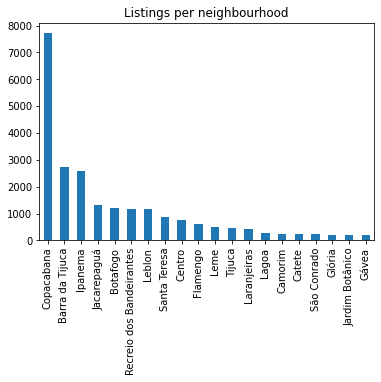

In [14]:
plt.title('Listings per neighbourhood')
listings_df['neighbourhood_cleansed'].value_counts()[:20].plot(kind='bar');

It seems that Copacabana is the hotspot of the city. Now let's find the number of listed neighbourhoods.

In [15]:
count = len(listings_df['neighbourhood_cleansed'].unique())
print('Rio has {} listed neighbourhoods'.format(count))

Rio has 151 listed neighbourhoods


The column `room_type` is worth taking a look, maybe it can tell a lot about the price of a listing. Let's take a closer look.

In [16]:
listings_df['room_type'].unique()

array(['Entire home/apt', 'Private room', 'Shared room', 'Hotel room'],
      dtype=object)

As we could see, the column has 4 possible values, ranging from entire apartaments to shared rooms. Now, let's see what their value looks like by using the mean.

In [17]:
df_room = listings_summary_df[['room_type', 'price']]
df_room.groupby(['room_type']).mean()

,price
room_type,
Entire home/apt,823.069277
Hotel room,325.212121
Private room,448.315758
Shared room,1456.738562


It's really strange that `shared room` has the biggest mean, maybe it's some outlier, let's plot the prices by room type to check on that.

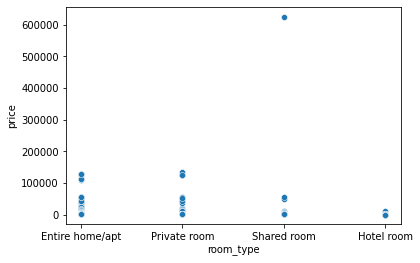

In [18]:
sns.scatterplot(x='room_type', y='price', data=listings_summary_df);

There it is! It's a shared room costing over 600.000 reais. In this case, the **median** is more interesting to analyze the price, as it is less sensible to outliers. The outliers will be handled soon in preprocessing.

In [19]:
df_room.groupby(['room_type']).median()

,price
room_type,
Entire home/apt,350
Hotel room,183
Private room,160
Shared room,100


Now we can conclude that entire apartaments are the **most expensive** listing type and shared rooms the **cheapest**. (IMHO hostels rocks =D)

Now, let's take a look at the price column.

In [20]:
listings_df['price'][:10]

0      $221.00
1      $307.00
2      $160.00
3      $273.00
4      $135.00
5      $484.00
6    $1,751.00
7      $540.00
8      $160.00
9      $782.00
Name: price, dtype: object

As seem above, the price needs some formatting as a model can only deal with numbers. We need to:
- Remove the `$` symbol
- Remove the comma

These steps will be done on preproccessing.

### Listing titles analysis 

In this part, I aim to investigate the most frequent words in listing titles, this way maybe we can find the most popular words. To do this, it's first necessary to convert titles to lower case in the cell below.

In [21]:
lowered_names = [name.lower() for name in listings_df['name'].astype('str')] 

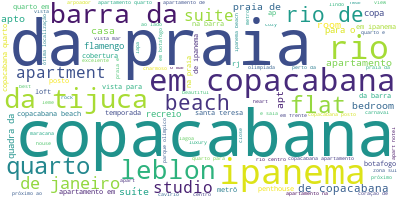

In [22]:
long_string = ','.join(lowered_names)
word_cloud = WordCloud(background_color="white",
                       max_words=100, contour_width=3,
                       contour_color='steelblue')

word_cloud.generate(long_string)
word_cloud.to_image()

In the word cloud, the bigger the word most frequent that word is. 

As Copacabana is the most common neighbor, it is not strange that it is among the most common words. The valuable information here is that hosts find it very important to put the location (Copacabana/Ipanema/Tijuca) or attraction ("beach") on the listing title. We have the first tip to new hosts on AirBnB: **in your listing title, describe some attractions on the listing name!**

With this result, we can draw a hypothesis that an important feature to price is location. We will confirm later if that's the case or not.

### Finding the best moment to travel 

The calendar dataset contains daily prices of every listing present on listings.csv. The criteria used to define the best moment is: which period of the year has lower prices?

In [23]:
calendar_df.head()

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,45766287,2021-02-23,f,$150.00,$150.00,2.0,1125.0
1,45764740,2021-02-24,f,$100.00,$100.00,1.0,4.0
2,45764740,2021-02-25,t,$100.00,$100.00,1.0,4.0
3,45764740,2021-02-26,t,$100.00,$100.00,1.0,4.0
4,45764740,2021-02-27,t,$100.00,$100.00,1.0,4.0


First, it's necessary to format the `price` column. 

In [24]:
def transform_price(dataset):
    dataset['price'] = [price[1:].replace(',','') for price in dataset['price'].astype(str)]
    dataset['price'] = dataset['price'].astype(float)
    
calendar_df = calendar_df.dropna()
transform_price(calendar_df)

Creating a new column to indicate the month.

In [25]:
calendar_df['month'] = [date.strftime('%Y-%m') for date in pd.to_datetime(calendar_df['date'])]

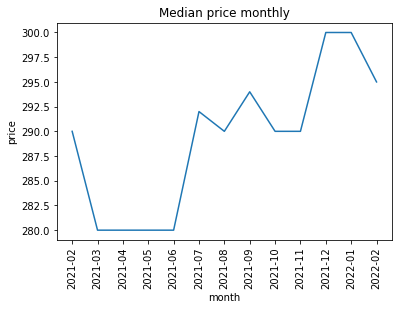

In [26]:
monthly_price = calendar_df[['month', 'price']].groupby(['month']).median()
plt.xticks(rotation='vertical')
plt.title('Median price monthly')
sns.lineplot(data=monthly_price, x='month', y='price');

The graph was made considering the monthly prices median during one year. 

The months from March to May have the lowest prices, which makes sense considering that it's an off-season period, and Brazilians tend to have vacations in July, where prices peak a little bit and it skyrockets by the end of the year, when a lot of people go to Rio to New Year's Eve. **So, considering this dataset, the months from March to May tend to have the lowest prices.**

Disclaimer: it may be as well an effect of the COVID-19 pandemic. Now Brazil is in its worst scenario ever.

<a id="pp"/>

## Preprocessing 

In [27]:
listings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26615 entries, 0 to 26614
Data columns (total 74 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            26615 non-null  int64  
 1   listing_url                                   26615 non-null  object 
 2   scrape_id                                     26615 non-null  int64  
 3   last_scraped                                  26615 non-null  object 
 4   name                                          26586 non-null  object 
 5   description                                   25160 non-null  object 
 6   neighborhood_overview                         14314 non-null  object 
 7   picture_url                                   26615 non-null  object 
 8   host_id                                       26615 non-null  int64  
 9   host_url                                      26615 non-null 

As we can see, there are some empty columns like `neighbourhood_group_cleansed`, `bathrooms`, `calendar_updated` and `license`, these columns will be dropped in the column below along with columns associated to identification of any kind. 

In [28]:
listings_df = listings_df.drop(columns=['id', 'scrape_id', 'host_id', 'neighbourhood_group_cleansed', 'bathrooms', 'calendar_updated', 'license'])

### Handling NaNs 

In [30]:
pd.options.display.min_rows = 80
listings_df.isnull().sum()

listing_url                                         0
last_scraped                                        0
name                                               29
description                                      1455
neighborhood_overview                           12301
picture_url                                         0
host_url                                            0
host_name                                          24
host_since                                         24
host_location                                     107
host_about                                      13720
host_response_time                               8016
host_response_rate                               8016
host_acceptance_rate                             9541
host_is_superhost                                  24
host_thumbnail_url                                 24
host_picture_url                                   24
host_neighbourhood                              11271
host_listings_count         

The columns `host_name`, `name` and `description` will be dropped as a regression model can't make sense of text data. 

Any columns with urls will be dropped. 

In [31]:
listings_df = listings_df.drop(columns=['description', 'name', 'listing_url', 'host_url', 'picture_url', 'host_name'])

In regards to NaNs in the `review_per_month` column, maybe it's because some listings never had a review, let's take a closer look by querying listings with 0 reviews.

In [32]:
listings_df.query('number_of_reviews == 0').shape

(9958, 61)

As we can see above, the number of listings with 0 reviews is **9958**, the exact value of NaNs in the `reviews_per_month` column, meaning that listings with 0 reviews received a NaN on the `reviews_per_month` column. As a model can't make sense of such value so I'll input it with 0. 

In [33]:
listings_df['reviews_per_month'] = listings_df['reviews_per_month'].fillna(0)

Columns associated with review such as `'reviews_per_month', 'review_scores_rating','review_scores_accuracy','review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'first_review' and 'last_review'` have so many NaNs that dropping those lines hardly would be beneficial as I would lose many other values in other columns, so I'll drop these columns. 

In [34]:
listings_df = listings_df.drop(columns=['first_review', 'last_review', 'reviews_per_month', 'review_scores_rating','review_scores_accuracy','review_scores_cleanliness',
                                        'review_scores_checkin',  'review_scores_communication', 'review_scores_location', 'review_scores_value'])

The columns `bedrooms` and `beds` have some NaNs, what doesn't make much sense, I'll consider these are listings that may have for example, a sofa other than a proper bed, and will fill NaNs with 1. For the bedrooms, I'll consider these are listings that don't have a bedroom space, for example a living room, and will fill this with 1 as well.

In [35]:
listings_df['bedrooms'] = listings_df['bedrooms'].fillna(1)
listings_df['beds'] = listings_df['beds'].fillna(1)

### Formatting columns 

Some columns need to be formatted:

- `host_acceptance_rate` and `host_response_rate` are represented in percentages and the `%` symbol will be removed and transformed to float.
- Many columns are represented with `True (t)` or `False(f)` values, in the cell below I make a function to transform these columns to a binary column.
- The `amenities` column comes with a list of amenities, this column will be transformed to indicate the quantity of amenities a listing has.
- The `baths` column is represented in plain text, assuming values such as `2 baths`, `1.5 baths` etc. This column will be transformed to keep only the numerical part as a float.
- The `price` column needs to be formatted to remove the `$` symbol, the `transform_price()` method declared earlier will be used for that.

In [36]:
def transform_to_binary(column, dataset):
    return [1 if line == 't' else 0 for line in dataset[column]]

In [37]:
listings_df['host_acceptance_rate'] = listings_df['host_acceptance_rate'].str.strip('%').astype(float)
listings_df['host_response_rate'] = listings_df['host_response_rate'].str.strip('%').astype(float)

listings_df['host_is_superhost'] = transform_to_binary('host_is_superhost', listings_df)
listings_df['instant_bookable'] = transform_to_binary('instant_bookable', listings_df)
listings_df['host_identity_verified'] = transform_to_binary('host_identity_verified', listings_df)
listings_df['instant_bookable'] = transform_to_binary('instant_bookable', listings_df)
listings_df['host_has_profile_pic'] = transform_to_binary('host_has_profile_pic', listings_df)
listings_df['has_availability'] = transform_to_binary('has_availability', listings_df)

listings_df['baths'] = listings_df['bathrooms_text'].str.lower()
listings_df['baths'] = listings_df['baths'].str.strip('baths')
listings_df['baths'] = listings_df['baths'].str.strip('shared ')
listings_df['baths'] = listings_df['baths'].str.strip('half-')
listings_df['baths'] = listings_df['baths'].str.strip('private')
listings_df['baths'] = [0 if value in ['', ' '] else value for value in listings_df['baths']]
listings_df['baths'] = listings_df['baths'].astype(float)

listings_df['amenities'] = [len(amenities_list.split(',')) for amenities_list in listings_df['amenities']]

transform_price(listings_df)

### Handling categorical variables 

Some categorical columns need to be handled, like `neighbourhood` and `room_type`. To handle this I'll use pandas built-in function `get_dummies()` that transforms each value in a column to a new binary columns indicating the presence or not of that value. An example can be seen below.


![dummies](images/dummies.png)

In [38]:
dummy_df = pd.get_dummies(data=listings_df, columns=['room_type'])

Initially, I transformed the `neighbourhood` column with `get_dummies()` but that created 151 new columns, which made the models really slow to train. I could still try ordinal encoding but it does't make sense considering there isn't a natural order of importance on neighbours names, so I decided to drop this column.

In [39]:
dummy_df = dummy_df.drop(columns=['neighbourhood'])

### Handling outliers

Let's first take a look at `price`, our target variable, and `beds`.

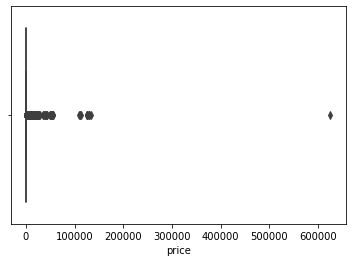

In [40]:
sns.boxplot(data=dummy_df, x='price');

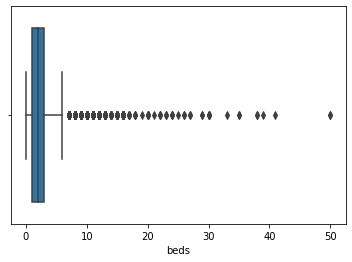

In [41]:
sns.boxplot(data=dummy_df, x='beds');

As we can see there are a lot of outliers! As linear models are very sensible to outliers I'll remove it using [Interquartile Range](https://en.wikipedia.org/wiki/Interquartile_range) defined in the method below. 

At first I tried removing outliers using only standard deviation, but that was giving me terrible results on R2 square when training the models. 

In [42]:
def get_max_fence(dataset, column):
    quartiles = dataset[column].quantile([0.25,0.75])
    first_quartile, third_quartile = quartiles.values[0], quartiles.values[1]
    interquartile_range = third_quartile - first_quartile
    max_fence = third_quartile + 1.5*(interquartile_range)
    return max_fence

price_fence = get_max_fence(dummy_df, 'price')
beds_fence = get_max_fence(dummy_df, 'beds')

print(f'Price fence: {price_fence}, beds fence: {beds_fence}')

Price fence: 1139.5, beds fence: 6.0


Now I'll drop that any line where price <= R$1139 and beds <= 6.  

In [43]:
model_df = dummy_df.query(f'price <= {price_fence} & beds <= {beds_fence}')

In [44]:
model_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23234 entries, 0 to 26614
Data columns (total 54 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   last_scraped                                  23234 non-null  object 
 1   neighborhood_overview                         12900 non-null  object 
 2   host_since                                    23214 non-null  object 
 3   host_location                                 23148 non-null  object 
 4   host_about                                    11281 non-null  object 
 5   host_response_time                            16717 non-null  object 
 6   host_response_rate                            16717 non-null  float64
 7   host_acceptance_rate                          15539 non-null  float64
 8   host_is_superhost                             23234 non-null  int64  
 9   host_thumbnail_url                            23214 non-null 

<a id="modeling"/>

## Modeling

Let's keep only the numerical columns.

In [45]:
model_df = model_df.select_dtypes(exclude='object')

And fill the remaining NaNs with its column mean.

In [46]:
fill_mean = lambda col: col.fillna(col.mean())
model_df = model_df.apply(fill_mean, axis=0)

For a comparison, I selected three ensemble methods, that combine many estimators together aiming a good generability as the famous Random Forest and Extra Trees. I give a special highlight to Histogram-based Gradient Boosting Regression, inspired by the fast and lightweight LightGBM, that performed the best.

I used Standard Scaler, that tranforms features to a normally distributed feature, as many machine learning estimators expect this. For splitting, I chose a test size of 30%. To avoid data leak from training to test set, I used sklearn standard `Pipeline` class.

In [51]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, HistGradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import numpy as np


X = model_df.drop(columns=['price'])
y = model_df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=33)

def evaluate(model):
    scaler = StandardScaler()
    pipeline = Pipeline([('scaler', scaler), ('model', model)])
    pipeline.fit(X_train, y_train)
    preds = pipeline.predict(X_test)
    r2 = r2_score(y_test, preds)
    mse = mean_squared_error(y_test, preds)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, preds)
    print('R2: {:.2f}, MSE: {:.2f}, RMSE: {:.2f}, MAE: {:.2f}'
          .format(r2, mse, rmse, mae))
    return pipeline

In [53]:
extra_trees = evaluate(ExtraTreesRegressor())
lgbm = evaluate(HistGradientBoostingRegressor())
random_forest = evaluate(RandomForestRegressor())

R2: 0.49, MSE: 30990.59, RMSE: 176.04, MAE: 123.49
R2: 0.52, MSE: 29354.02, RMSE: 171.33, MAE: 118.82
R2: 0.48, MSE: 31339.15, RMSE: 177.03, MAE: 125.05
R2: -56831.90, MSE: 3449278141.89, RMSE: 58730.56, MAE: 851.23


As we can see above, LightGBM performed the best, with a R2 score of 0.52. And the worst was Random Forest. 

### Model explanability

As a way to explain models behavior, it's interesting to plot the most important features with sci-kit built-in `feature_importances_` attributes on tree based models. The bigger the value, more important that feature is to a listing price.

In [54]:
def plot_feature_importances(model):
    importances = pd.DataFrame(model['model'].feature_importances_, index = X_train.columns,
                               columns=['importance']).sort_values('importance', ascending=False)
    sns.barplot(y=importances.index[:15], x=importances['importance'][:15])
    plt.title('Top 15 features')
    plt.ylabel('feature')

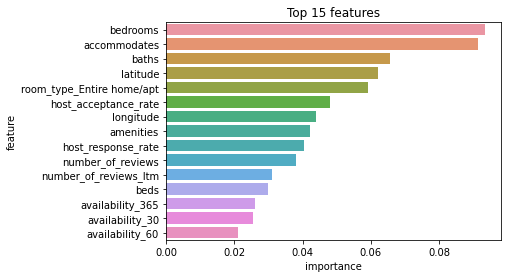

In [55]:
plot_feature_importances(extra_trees)

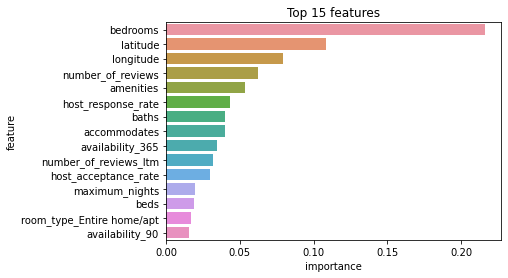

In [56]:
plot_feature_importances(random_forest)

From both graphs, we can notice that `bedroom` and `accommodates` converged to be an important feature to predict prices. `Baths` played an important role on the Extra Trees model but not in Random Forest.

And surprisingly, `latitude` and `longitude` had some significant influence, with these results I can affirm that **location definitely has a moderate influence on listing prices, but no more than the number of bedrooms or the number of people it accommodates**.   

<a id="challenges"/>

## Challenges and future work

It was especially challenging to find a suitable method for removing outliers. The R2 score of 0.52 could be better. I tried to merge the calendar dataset with listings, but it ended up having too many lines, and it was impossible to train a model without getting out of RAM, even in Google Colab. As an interesting future work, this could be addressed maybe with some data engineering practices/frameworks. 

<a id="ack"/>

## Acknowledgements

Kudos to this [notebook](https://www.kaggle.com/allanbruno/helping-regular-people-price-listings-on-airbnb) from Allan Bruno, where I could find a functional way to remove outliers properly! 

To the awesome [Inside Airbnb](http://insideairbnb.com/) for providing the datasets!